# PROJECT FILES

Dataset: https://www.kaggle.com/thedagger/pokemon-generation-one



In [ ]:
im_shape = 96
split = 0.80
limit = 200
min_size = 0

In [ ]:
import os
import cv2 as cv
import random
import matplotlib.pyplot as plt
import numpy as np
import time
import shutil
import os
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import math

In [ ]:
def download_data():
  if "dataset" not in os.listdir():
    # download the dataset
    !gdown --id 19cYp4kDOkqnfQkwKptI7JfgjDcFVppYh

    # unzip to the current location
    !unzip -o dataset.zip 

    # delete the zip file
    !rm dataset.zip

def dhash(image, hashSize=16):
  gray = cv.cvtColor(np.float32(image), cv.COLOR_BGR2GRAY)
  resized = cv.resize(gray, (hashSize + 1, hashSize))
  # compute the (relative) horizontal gradient between adjacent
  # column pixels
  diff = resized[:, 1:] > resized[:, :-1]
  # convert the difference image to a hash and return it
  return sum([2 ** i for (i, v) in enumerate(diff.flatten()) if v])

def move_file(path2file, new_path, file_name):
  moveTo = os.path.join(new_path, file_name)
  shutil.move(path2file, moveTo)

def clean_data():
  os.chdir("/content")
  download_data()
  if "discarded" in os.listdir():
    return

  imgs = []
  my_path = r"dataset"
  new_path = r"discarded"
  if "discarded" not in os.listdir():
    os.mkdir("discarded")

  count = 0
  # print(os.listdir(my_path))
  for r, d, f in os.walk(my_path):
    
    # os.chdir(r)
    # print(r, d, f)
    for file in f:
      # print("os.path.join(r, file)")
      path = os.path.join(r, file)
      # print(os.path.isfile(path), path)
      if os.path.isfile(path):
        try:                
          image = cv.imread(path)
          im_hash = dhash(image)
          imgs.append([r, path, im_hash, file])
          # print("loaded", path)
        except:
          print("Can't read:", path)
          move_file(path, new_path, file)
  
      if len(imgs) >= count+500:
        count = len(imgs)

  count = 0
  uniques = imgs.copy()
  delete = False
  for cl_path, path, img, f in imgs:
    uniques = uniques[-(len(uniques)-1):]
    for u_cl_path, u_path, u_img, u_f in uniques:
      if img == u_img and not f == u_f:
        try:
          print("Found Dublicate:", f, "==", u_f, "\n", u_path)
          move_file(u_path, new_path, u_f)
          # os.remove(u_path) 
          count+=1
          if cl_path != u_cl_path:
            delete=True
        except:
          continue
    if delete:
      print("Moving Original:", f, "==")
      move_file(path, new_path, f)
      # os.remove(u_path) 
      count+=1
      delete=False

  print("# Found non-usable images: ", count)

clean_data() # to get rid of dublicates

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: dataset/Pikachu/00000008.jpg  
  inflating: dataset/Pikachu/00000009.png  
  inflating: dataset/Pikachu/00000010.png  
  inflating: dataset/Pikachu/00000011.png  
  inflating: dataset/Pikachu/00000012.png  
  inflating: dataset/Pikachu/00000013.png  
  inflating: dataset/Pikachu/00000014.png  
  inflating: dataset/Pikachu/00000015.png  
  inflating: dataset/Pikachu/00000016.jpg  
  inflating: dataset/Pikachu/00000017.jpg  
  inflating: dataset/Pikachu/00000018.jpg  
  inflating: dataset/Pikachu/00000019.jpg  
  inflating: dataset/Pikachu/00000020.png  
  inflating: dataset/Pikachu/00000021.png  
  inflating: dataset/Pikachu/00000022.jpg  
 extracting: dataset/Pikachu/00000023.png  
  inflating: dataset/Pikachu/00000024.png  
  inflating: dataset/Pikachu/00000025.png  
  inflating: dataset/Pikachu/00000026.png  
  inflating: dataset/Pikachu/00000027.jpg  
  inflating: dataset/Pikachu/00000028.jpg  
  inflating: dataset/Pikachu/

In [ ]:
data_augmentation = tf.keras.Sequential([

  layers.experimental.preprocessing.RandomTranslation(
    0.2, 0.2, fill_mode='reflect', interpolation='bilinear'
  ),
  layers.experimental.preprocessing.RandomContrast(0.2),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.Resizing(im_shape, im_shape),
  # layers.experimental.preprocessing.Rescaling(1./255),
])

def data_aug(im):
  # print(im)
  try:
    im = tf.expand_dims(im, 0)
    im = np.array(data_augmentation(im)[0])
    
  except:
    im = tf.expand_dims(im[0], 0)
    im = np.array(data_augmentation(im)[0])

  return im


In [ ]:
def create_dataset(im_shape=100, limit_size=None):

  tr_x = []
  tr_y = []
  te_x = []
  te_y = []
  label2id = []
  discarded = 0

  # path = "drive/MyDrive/VP - Project/"
  path = "dataset"

  classes = os.listdir(path)
  augmented_count = 0
  test_augmented = 0
  for index, class_id in enumerate(classes):
    
    # to get the exact location of each class    
    class_path = os.path.join(path, class_id) 
    # looping over all images in each class
    count=0
    test_count=0
    
    if len(os.listdir(class_path)) >= min_size:
      # print(len(label2id)+1, class_id, len(os.listdir(class_path)))
      label2id.append(class_id)
      for image_id in os.listdir(class_path): 

        if limit_size:
          length = math.ceil((1-split)*limit_size)
        else:
          length = math.ceil((1-split)*count)

        im_path = os.path.join(class_path, image_id)
        try:
          # load the image
          im = cv.imread(im_path) 
          # to be able to use plt.imshow
          im = cv.cvtColor(im, cv.COLOR_BGR2RGB) 
          resized_im = cv.resize(im, (im_shape, im_shape)) 
          if limit_size:
            if limit_size > count:
              tr_x.append(resized_im)
              tr_y.append(len(label2id)-1)
              count+=1
            elif limit_size*(1-split) > test_count:
              te_x.append(resized_im)
              te_y.append(len(label2id)-1)
              test_count+=1
            else:
              break
          else:              
              if len(os.listdir(class_path)) > count*(1+(1-split)):
                tr_x.append(resized_im)
                tr_y.append(len(label2id)-1)
                count+=1
              elif count*(1-split) > test_count:
                te_x.append(resized_im)
                te_y.append(len(label2id)-1)
                test_count+=1
        except:
          print(im_path, 'can\'t read')
          discarded += 1

      # print(f"{index+1}/{len(classes)}  1 {label2id[index]} -> train: {count} - test: {test_count}")
      if limit_size:
        while limit_size*(1-split) > test_count*2:
          te_x.append(tr_x[-1:][0])
          te_y.append(tr_y[-1:][0])

          tr_x = tr_x[:-1]
          tr_y = tr_y[:-1]

          count -= 1
          test_count+=1

        # print(f"{index+1}/{len(classes)}  2 {label2id[index]} -> train: {count} - test: {test_count}")

        while ((limit_size*(1-split)) - test_count > 0):
          for im in te_x[-test_count:]:
            
            new_im = data_aug(im)
            te_x.append(new_im)
            te_y.append(len(label2id)-1)
            test_count+=1
            test_augmented+=1

        # print(f"{index+1}/{len(classes)}  3 {label2id[index]} -> train: {count} - test: {test_count}")

        while (count < limit_size):
          for image_id in os.listdir(class_path):
            im_path = os.path.join(class_path, image_id)
            im = cv.imread(im_path)
            im = cv.cvtColor(im, cv.COLOR_BGR2RGB) 
            resized_im = cv.resize(im, (im_shape, im_shape))
            
            if limit_size <= count:
              break
            else:
              new_im = data_aug(resized_im)

              tr_x.append(new_im)
              tr_y.append(len(label2id)-1)
              count+=1
              augmented_count+=1

        print(f"{index+1}/{len(classes)} {label2id[len(label2id)-1]} -> train: {count} - test: {test_count}")
  print("# Classes:", len(label2id))
  print(f"# Train: {len(tr_x)} - # Augmented: {augmented_count}")
  print(f"# Train: {len(te_x)} - # Augmented: {test_augmented}")
  print("# Discarded:", discarded)


  return np.array(tr_x)*(1./255), np.array(tr_y), np.array(te_x)*(1./255), np.array(te_y), label2id

train_x, train_y , test_x, test_y, class_ids = create_dataset(im_shape=im_shape, limit_size=limit)

1/149 Bellsprout -> train: 200 - test: 40
2/149 Shellder -> train: 200 - test: 40
3/149 Sandslash -> train: 200 - test: 40
4/149 Sandshrew -> train: 200 - test: 40
5/149 Machop -> train: 200 - test: 40
6/149 Articuno -> train: 200 - test: 40
7/149 Poliwrath -> train: 200 - test: 40
8/149 Caterpie -> train: 200 - test: 40
9/149 Nidorino -> train: 200 - test: 40
10/149 Raticate -> train: 200 - test: 40
11/149 Growlithe -> train: 200 - test: 40
12/149 Electabuzz -> train: 200 - test: 40
13/149 Rattata -> train: 200 - test: 40
14/149 Hitmonlee -> train: 200 - test: 40
15/149 Alakazam -> train: 200 - test: 40
16/149 Mankey -> train: 200 - test: 40
17/149 Kakuna -> train: 200 - test: 40
18/149 Kadabra -> train: 200 - test: 40
19/149 Raichu -> train: 200 - test: 40
20/149 Slowbro -> train: 200 - test: 40
21/149 Blastoise -> train: 200 - test: 40
22/149 Hypno -> train: 200 - test: 40
23/149 Porygon -> train: 200 - test: 40
24/149 Exeggcute -> train: 200 - test: 40
25/149 Seadra -> train: 200 -

In [ ]:
def dublicate_checker(a, b):
  count = 0
  for x, i in enumerate(a):
    for y, j in enumerate(b):
      if (i==j).all():
        count += 1
  return count

# dublicate_checker(train_x, test_x)

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (train_x, train_y)).shuffle(10000).batch(128)

test_ds = tf.data.Dataset.from_tensor_slices(
    (test_x, test_y)).batch(128)

Training images

Test images


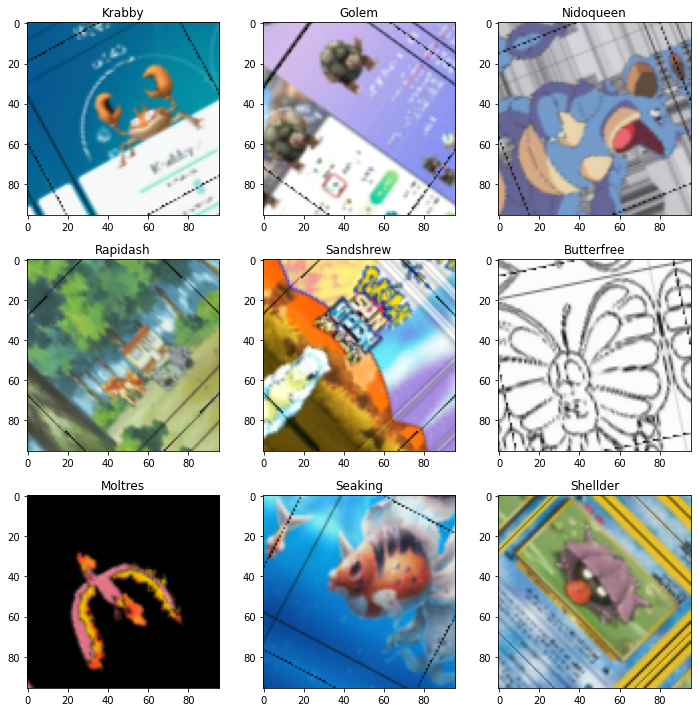

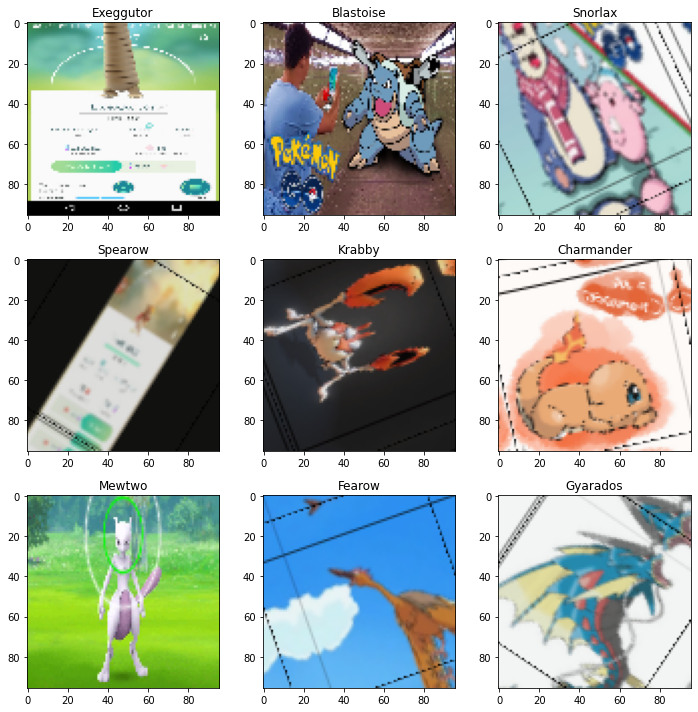

In [ ]:
def print_random(imgs, labels):
  plt.figure(figsize=(10, 10))
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    ix = random.randint(0, len(imgs))
    # print(ix)
    plt.imshow(imgs[ix])
    plt.title(class_ids[labels[ix]])
    # plt.axis("off")
  plt.tight_layout()


print_random(train_x, train_y)
print_random(test_x, test_y)

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
from datetime import datetime
current_time = datetime.now().strftime("%Y%m%d-%H %M %S ")
train_log_dir = 'logs/'

train_summary_writer = tf.summary.create_file_writer(train_log_dir)

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss', dtype=tf.float32)
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss', dtype=tf.float32)
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [ ]:
@tf.function
def train_step(the_model, images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = the_model(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, the_model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, the_model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

In [ ]:
@tf.function
def test_step(the_model, images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = the_model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [ ]:
def train (the_model, EPOCHS):
  current_val = 0
  for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
      train_step(the_model, images, labels)

    for test_images, test_labels in test_ds:
      test_step(the_model, test_images, test_labels)

    print(
      f'Epoch {epoch + 1}, '
      f'Loss: {np.around(train_loss.result(), 2)}, '
      f'Accuracy: {train_accuracy.result() * 100}, '
      f'Test Loss: {np.around(test_loss.result(), 2)}, '
      f'Test Accuracy: {np.around(test_accuracy.result() * 100, 2)}'
    )

    # Tensorboard >>
    with train_summary_writer.as_default():
      tf.summary.scalar('Train_loss', train_loss.result(), step=epoch)
      tf.summary.scalar('Train_acc', train_accuracy.result() * 100, step=epoch)
      tf.summary.scalar('Test_loss', test_loss.result(), step=epoch)
      tf.summary.scalar('Test_acc', test_accuracy.result(), step=epoch)

    if test_accuracy.result() > current_val:
      current_val = test_accuracy.result()
      the_model.save('my_model2.h5')
      print(f"Model saved, val. acc.: {test_accuracy.result()*100}")

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), padding = 'same', activation='relu', input_shape=(im_shape, im_shape, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), padding = 'same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (3, 3), padding = 'same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(256, (3, 3), padding = 'same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, (3, 3), padding = 'same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.50))

model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.50))
model.add(layers.Dense(len(class_ids), activation="softmax"))

# model.summary()

# train(model, 50)

In [ ]:
predict_random(model_res)

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('my_model2.h5')
new_model.compile(optimizer,
              loss_object,
              test_accuracy)

# for test_images, test_labels in test_ds:
# Evaluate the restored model
loss, acc = new_model.evaluate(test_x, test_y, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

print(new_model.predict(test_x).shape)

In [ ]:
%tensorboard --logdir logs/

In [ ]:
def predict_random(the_model):
  plt_x = []
  plt_y = []
  for index in range(9):
    i = random.randint(0, len(test_x)-1)
    plt_x.append(test_x[i])
    plt_y.append(class_ids[test_y[i]])

  preds = the_model.predict(np.asarray(plt_x)) # Predicting image

  plt.figure(figsize=(10, 10))
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(plt_x[i])

    # calculating how sure the model is
    p = preds[i][np.argmax(preds[i])]    
    q = (p - min(preds[i]))/sum(preds[i])-min(preds[i])
    
    title = f'True: {plt_y[i]} \nPred: {class_ids[np.argmax(preds[i])]} {round((q)*100, 2)}%'
    plt.title(title)

    plt.axis("off")
  plt.tight_layout()

In [ ]:
one_hot_train = tf.keras.utils.to_categorical(
    train_y, num_classes=len(class_ids), dtype='float32'
)
one_hot_test = tf.keras.utils.to_categorical(
    test_y, num_classes=len(class_ids), dtype='float32'
)

In [ ]:
from keras.applications.resnet50 import ResNet50
from keras.models import Sequential
from keras.layers import *
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense, BatchNormalization, Dropout
from keras import Model

resnet = ResNet50(include_top=False,weights='imagenet',input_shape = (im_shape,im_shape,3))

layer_out = GlobalAveragePooling2D()(resnet.output)
layer_out = Dense(512, activation='relu')(layer_out)
layer_out = BatchNormalization()(layer_out)
layer_out = Dropout(0.50)(layer_out)
layer_out = Dense(256, activation='relu')(layer_out)
layer_out = BatchNormalization()(layer_out)
layer_out = Dropout(0.50)(layer_out)
layer_out = Flatten()(resnet.output)
layer_out = Dense(len(class_ids), activation='softmax')(layer_out)

# our layers
# x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
# prediction = Dense(len(class_ids), activation='softmax')(x)


model_res = Model(inputs=resnet.input, outputs = layer_out)

# train(model_res, 20)

from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('best_model.hdf5', verbose = 1, monitor = 'val_accuracy', save_best_only = True)

model_res.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

history = model_res.fit(np.asarray(train_x), np.asarray(one_hot_train), epochs=20,
                     validation_data=(np.asarray(test_x), np.asarray(one_hot_test)), shuffle=True, callbacks = [checkpoint])

Epoch 1/20
932/932 [==============================] - ETA: 0s - loss: 4.5266 - accuracy: 0.0843
Epoch 00001: val_accuracy improved from -inf to 0.09366, saving model to best_model.hdf5
932/932 [==============================] - 4813s 5s/step - loss: 4.5266 - accuracy: 0.0843 - val_loss: 5.9666 - val_accuracy: 0.0937
Epoch 2/20
929/932 [============================>.] - ETA: 14s - loss: 3.5460 - accuracy: 0.1866

Text(0.5, 1.0, 'loss')

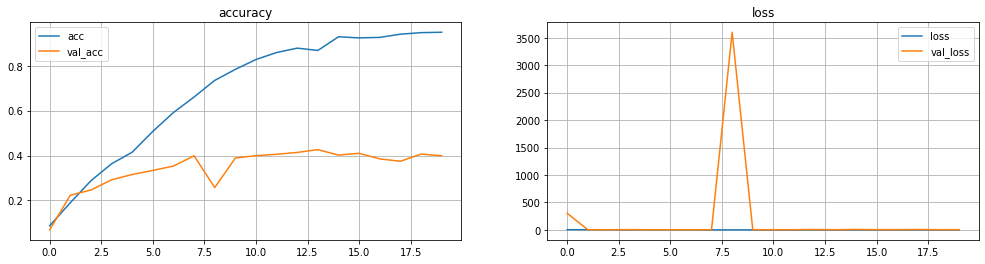

In [ ]:
# Plot learning curves
fig = plt.figure(figsize = (17, 4))

plt.subplot(121)
plt.plot(history.history['accuracy'], label = 'acc')
plt.plot(history.history['val_accuracy'], label = 'val_acc')
plt.legend()
plt.grid()
plt.title(f'accuracy')

plt.subplot(122)
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend()
plt.grid()
plt.title(f'loss')

In [ ]:
from keras.applications.vgg16 import VGG16
vgg = VGG16(include_top=False,weights='imagenet',input_shape = (im_shape,im_shape,3))
# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

# our layers
layer_out = Flatten()(vgg.output)
layer_out = Dense(512, activation='relu')(layer_out)
layer_out = BatchNormalization()(layer_out)
layer_out = Dropout(0.50)(layer_out)
layer_out = Dense(256, activation='relu')(layer_out)
layer_out = BatchNormalization()(layer_out)
layer_out = Dropout(0.50)(layer_out)
layer_out = Dense(len(class_ids), activation='softmax')(layer_out)
vgg_model = Model(inputs=vgg.input, outputs=layer_out)
# vgg_model.summary()

from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('best_model.hdf5', verbose = 1, monitor = 'val_accuracy', save_best_only = True)

vgg_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = vgg_model.fit(np.asarray(train_x), np.asarray(one_hot_train), epochs=20,
                     validation_data=(np.asarray(test_x), np.asarray(one_hot_test)), shuffle=True, callbacks = [checkpoint])

Epoch 1/20
931/932 [============================>.] - ETA: 0s - loss: 4.6945 - accuracy: 0.0746
Epoch 00001: val_accuracy improved from -inf to 0.21023, saving model to best_model.hdf5
932/932 [==============================] - 63s 68ms/step - loss: 4.6943 - accuracy: 0.0747 - val_loss: 3.6264 - val_accuracy: 0.2102
Epoch 2/20
931/932 [============================>.] - ETA: 0s - loss: 3.7297 - accuracy: 0.1797
Epoch 00002: val_accuracy improved from 0.21023 to 0.27964, saving model to best_model.hdf5
932/932 [==============================] - 63s 67ms/step - loss: 3.7296 - accuracy: 0.1797 - val_loss: 3.2192 - val_accuracy: 0.2796
Epoch 3/20
931/932 [============================>.] - ETA: 0s - loss: 3.3712 - accuracy: 0.2354
Epoch 00003: val_accuracy improved from 0.27964 to 0.31468, saving model to best_model.hdf5
932/932 [==============================] - 63s 67ms/step - loss: 3.3710 - accuracy: 0.2354 - val_loss: 3.0105 - val_accuracy: 0.3147
Epoch 4/20
931/932 [====================

Text(0.5, 1.0, 'loss')

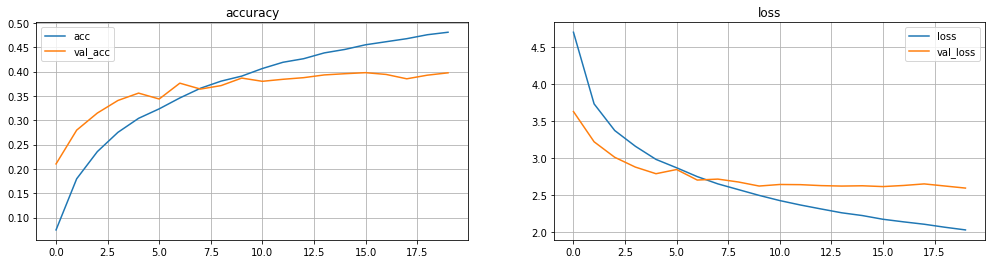

In [ ]:
# Plot learning curves
fig = plt.figure(figsize = (17, 4))

plt.subplot(121)
plt.plot(history.history['accuracy'], label = 'acc')
plt.plot(history.history['val_accuracy'], label = 'val_acc')
plt.legend()
plt.grid()
plt.title(f'accuracy')

plt.subplot(122)
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend()
plt.grid()
plt.title(f'loss')